In [1]:
import matplotlib.pyplot as plt
import sys, os
sys.path.append('../src/')
import sys
from lib.dataset import *
from lib.loss import *
from lib.utils import *


import torch
from torch.utils.data import DataLoader
from SFNP.model import Model as SFNP_Model
from transformer.model import Model as Transformer_Model
from MFNP.model import Model as MFNP_Model
from SF_Attn.model import Model as SF_Attn_Model
import os, yaml, glob, dill
from tqdm import tqdm

from eval_utils import *
import os
cwd = os.getcwd()

In [2]:
def split_context_target(x, context_percentage_low, context_percentage_high):
    """Helper function to split randomly into context and target"""
    context_percentage = np.random.uniform(
        context_percentage_low, context_percentage_high)
    n_context = int(x.shape[1]*context_percentage)
    ind = np.arange(x.shape[1])
    mask = np.random.choice(ind, size=n_context, replace=False)
    others = np.delete(ind, mask)

    return mask, others

class Evaluator():
    def __init__(self, dirpath, Model):
        self.dirpath = dirpath

        if Model == Transformer_Model:
            self.model_type = "forward"
        elif Model == MFNP_Model:
            self.model_type = "multi"
        elif Model == SF_Attn_Model:

            self.model_type = "attentive"
        else:
            self.model_type = "sfnp"

        self.config = yaml.safe_load(open(f"{dirpath}/saved_config.yaml"))
        self.init_dataloader()
        self.Model = Model
        self.init_model()

    def init_model(self):
        self.device = torch.device('cuda')
        model_dict = torch.load(f"{self.dirpath}/best.pt", map_location=torch.device('cuda'))
        model = self.Model(model_dict['config']['model']).to(self.device)

        model.load_state_dict(model_dict['model'])
        model.eval()
        self.model = model

    def init_dataloader(self):
        l2_x_data = sorted(glob.glob(f"{self.config['data_dir']}/SPCAM5/inputs_*"), key=sort_fn)
        l2_y_data = sorted(glob.glob(f"{self.config['data_dir']}/SPCAM5/outputs_*"), key=sort_fn)
        l1_x_data = sorted(glob.glob(f"{self.config['data_dir']}/CAM5/inputs_*"), key=sort_fn)
        l1_y_data = sorted(glob.glob(f"{self.config['data_dir']}/CAM5/outputs_*"), key=sort_fn)

        n = int(365*0.8)
        self.l2_x_train = l2_x_data[:n]
        self.l2_y_train = l2_y_data[:n]
        self.l2_x_valid = l2_x_data[n:365]
        self.l2_y_valid = l2_y_data[n:365]
        self.l2_x_test = l2_x_data[365:]
        self.l2_y_test = l2_y_data[365:]
        self.l1_x_train = l1_x_data[:n]
        self.l1_y_train = l1_y_data[:n]
        self.l1_x_valid = l1_x_data[n:365]
        self.l1_y_valid = l1_y_data[n:365]
        self.l1_x_test = l1_x_data[365:]
        self.l1_y_test = l1_y_data[365:]
        l1_x_scaler_minmax = dill.load(open(f"../../scalers/x_CAM5_minmax_scaler.dill", 'rb'))
        l1_y_scaler_minmax = dill.load(open(f"../../scalers/y_CAM5_minmax_scaler.dill", 'rb'))

        l2_x_scaler_minmax = dill.load(open(f"../../scalers/x_SPCAM5_minmax_scaler.dill", 'rb'))
        l2_y_scaler_minmax = dill.load(open(f"../../scalers/y_SPCAM5_minmax_scaler.dill", 'rb'))

        # Change to first 26 variables
        l2_y_scaler_minmax.min = l2_y_scaler_minmax.min[:26]
        l2_y_scaler_minmax.max = l2_y_scaler_minmax.max[:26]
        l1_y_scaler_minmax.min = l1_y_scaler_minmax.min[:26]
        l1_y_scaler_minmax.max = l1_y_scaler_minmax.max[:26]

        if self.model_type != "multi":
            trainset = l2Dataset(self.l2_x_train, self.l2_y_train, x_scaler=l2_x_scaler_minmax, y_scaler=l2_y_scaler_minmax, variables=26)
            self.trainloader = DataLoader(trainset, batch_size=self.config['batch_size'], shuffle=True, drop_last=False, \
                                            num_workers=4, pin_memory=True)
            validset = l2Dataset(self.l2_x_valid, self.l2_y_valid, x_scaler=l2_x_scaler_minmax, y_scaler=l2_y_scaler_minmax, variables=26)
            self.validloader = DataLoader(validset, batch_size=self.config['batch_size'], shuffle=False, drop_last=False, \
                                            num_workers=4, pin_memory=True)
            testset = l2Dataset(self.l2_x_test, self.l2_y_test, x_scaler=l2_x_scaler_minmax, y_scaler=l2_y_scaler_minmax, variables=26)
            self.testloader = DataLoader(testset, batch_size=self.config['batch_size'], shuffle=False, drop_last=False, \
                                        num_workers=4, pin_memory=True)
        else:
            trainset = MutliDataset(self.l1_x_train, self.l1_y_train, self.l2_x_train, self.l2_y_train,
                                            l1_x_scaler=l1_x_scaler_minmax, l1_y_scaler=l1_y_scaler_minmax,
                                            l2_x_scaler=l2_x_scaler_minmax, l2_y_scaler=l2_y_scaler_minmax, nested=self.config['nested'], variables=[26, 26])
            self.trainloader = DataLoader(trainset, self.config['batch_size'], shuffle=True, drop_last=False, num_workers=0, pin_memory=True)

            validset = MutliDataset(self.l1_x_valid, self.l1_y_valid, self.l2_x_valid, self.l2_y_valid,
                                    l1_x_scaler=l1_x_scaler_minmax, l1_y_scaler=l1_y_scaler_minmax,
                                    l2_x_scaler=l2_x_scaler_minmax, l2_y_scaler=l2_y_scaler_minmax, nested=self.config['nested'], variables=[26, 26])
            self.validloader = DataLoader(validset, self.config['batch_size'], shuffle=False, drop_last=False, num_workers=0, pin_memory=True)
            testset = MutliDataset(self.l1_x_test, self.l1_y_test, self.l2_x_test, self.l2_y_test, l1_x_scaler=l1_x_scaler_minmax, l1_y_scaler=l1_y_scaler_minmax, nested=self.config['nested'], variables=[26, 26])
            self.testloader = DataLoader(testset, self.config['batch_size'], shuffle=False, drop_last=False, num_workers=0, pin_memory=True)

        self.l2_y_scaler_minmax = l2_y_scaler_minmax

    def get_metrics(self, loader):
        self.get_R_stats(loader)
        self.r = self.ssxym / np.sqrt(self.ssxm * self.ssym)
        return self.non_mae, self.nmae, self.r

    def forward_pass(self, data):
        with torch.no_grad():
            if self.model_type == "multi":
                l1_x, l1_y, l2_x, l2_y = data
                l1_x = l1_x.reshape(-1, 1, l1_x.shape[-1]).to(device)
                l1_y = l1_y.reshape(-1, 1, l1_y.shape[-1]).to(device)
            else:
                l2_x, l2_y = data
                l2_x, l2_y = l2_x.to(device), l2_y.to(device)

            if self.model_type != "attentive":
                l2_x = l2_x.reshape(-1, 1, l2_x.shape[-1]).to(device)
                l2_y = l2_y.reshape(-1, 1, l2_y.shape[-1]).to(device)

            if self.model_type == "forward":
                l2_output_mu = self.model(l2_x)
                l2_truth = l2_y
            elif self.model_type == "multi":
                l1_output_mu, l1_output_cov, l2_output_mu, l2_output_cov, l1_y_truth,\
                    l2_truth, l1_z_mu_all, l1_z_cov_all, l1_z_mu_c, l1_z_cov_c, \
                    l2_z_mu_all, l2_z_cov_all, l2_z_mu_c, l2_z_cov_c = self.model(l1_x, l1_y, l2_x, l2_y)
            elif self.model_type == "attentive":
                mask, others = split_context_target(l2_x, l2_y, self.config['model']['context_percentage_low'], 
                                                                                self.config['model']['context_percentage_high'])
                context_x, context_y, target_x, l2_truth = l2_x[:, mask], l2_y[:, mask], l2_x[:, others], l2_y[:, others]
                l2_output_mu, l2_output_cov = self.model(context_x, context_y, target_x)
                self.mask = mask
            else:
                l2_output_mu, l2_output_cov, l2_truth, l2_z_mu_all, \
                        l2_z_cov_all, l2_z_mu_c, l2_z_cov_c = self.model(l2_x, l2_y)
            
            non_y_pred = self.l2_y_scaler_minmax.inverse_transform(l2_output_mu.squeeze().cpu().numpy())
            non_y = self.l2_y_scaler_minmax.inverse_transform(l2_truth.squeeze().cpu().numpy())
            return non_y, non_y_pred

    def get_R_stats(self, loader):
        self._get_stats(loader)
        self.ssxm = 0
        self.ssxym = 0
        self.ssym = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(loader, total=len(loader))):
                if self.model_type == "attentive":
                    n_mb = 9
                    data = [d[:, ::int(n_mb)] for d in data]

                    for b in range(n_mb): # Split into batches due to GPU limit
                        non_y, non_y_pred = self.forward_pass([d[:, b::n_mb] for d in data])

                        self.ssxm += ((non_y - self.y_mean)**2).sum(0)
                        self.ssym += ((non_y_pred - self.y_pred_mean)**2).sum(0)
                        self.ssxym += ((non_y - self.y_mean) * (non_y_pred - self.y_pred_mean)).sum(0)
                else:
                    non_y, non_y_pred = self.forward_pass(data)
                self.ssxm += ((non_y - self.y_mean)**2).sum(0)
                self.ssym += ((non_y_pred - self.y_pred_mean)**2).sum(0)
                self.ssxym += ((non_y - self.y_mean) * (non_y_pred - self.y_pred_mean)).sum(0)
            # Get average
            self.ssxm /= self.n_total
            self.ssym /= self.n_total
            self.ssxym /= self.n_total

    def _get_stats(self, loader):
        self.n_total = 0
        self.x_total = 0
        self.y_total = 0
        self.xy_total = 0
        self.x2_total = 0
        self.y2_total = 0
        self.y_mean = 0
        self.y_pred_mean = 0
        self.nmae = 0
        self.non_mae = 0

        with torch.no_grad():
            for i, data in enumerate(tqdm(loader, total=len(loader))):
                if self.model_type == "attentive":
                    n_mb = 9
                    data = [d[:, ::int(n_mb)] for d in data]
                    for b in range(n_mb): # Split into batches due to GPU limit
                        non_y, non_y_pred = self.forward_pass([d[:, b::n_mb] for d in data])
                        non_mae = mae_metric(non_y_pred, non_y, mean=False)

                        self.y_mean += non_y.sum(axis=0)
                        self.y_pred_mean += non_y_pred.sum(axis=0)
                        self.non_mae += non_mae.sum(axis=0)
                        self.n_total += non_y.shape[0]
                        self.x_total += non_y.sum(axis=0)
                        self.y_total += non_y_pred.sum(axis=0)
                        self.x2_total += (non_y ** 2).sum(axis=0)
                        self.y2_total += (non_y_pred ** 2).sum(axis=0)
                        self.xy_total += (non_y_pred * non_y).sum(axis=0)
                else:
                    non_y, non_y_pred = self.forward_pass(data)

                    non_mae = mae_metric(non_y_pred, non_y, mean=False)

                    self.y_mean += non_y.sum(axis=0)
                    self.y_pred_mean += non_y_pred.sum(axis=0)
                    self.non_mae += non_mae.sum(axis=0)
                    self.n_total += non_y.shape[0]
                    self.x_total += non_y.sum(axis=0)
                    self.y_total += non_y_pred.sum(axis=0)
                    self.x2_total += (non_y ** 2).sum(axis=0)
                    self.y2_total += (non_y_pred ** 2).sum(axis=0)
                    self.xy_total += (non_y_pred * non_y).sum(axis=0)

        self.y_mean /= self.n_total
        self.y_pred_mean /= self.n_total
        self.nmae /= self.n_total
        self.non_mae /= self.n_total
        self.nmae = np.abs(np.sqrt(self.non_mae / self.n_total) / np.abs(self.y_mean))


    def plot_scenario(self):
        for i, data in enumerate(tqdm(self.testloader, total=len(self.testloader))):
            if self.model_type != "attentive":
                x, y = data
                non_y, non_y_pred = self.forward_pass(data)
                print(x.shape, y.shape)
                print(non_y.shape, non_y_pred.shape)

            break
        return self.losses


In [3]:
SFNP_path = "logs/SFNP_train_seed0_lr0.000168_bs_1_Tue Feb 28 01:09:51 2023"
Transformer_path = "logs/transformer_tune_seed0_lr7.7e-05_bs_1_Tue Feb 28 09:39:20 2023"
MFNP_path = "logs/mfnp_tune_seed0_lr9.9e-05_bs_1_Tue Feb 28 10:58:15 2023"
SF_Attn_path = "logs/sfattn_train_seed0_lr0.000139_bs_1_Tue Feb 28 22:31:26 2023"

In [4]:
os.chdir(os.path.join(cwd, "../src/SFNP"))
evaluator_sfnp = Evaluator(SFNP_path, SFNP_Model)
# os.chdir(os.path.join(cwd, "../src/transformer"))
# evaluator_transformer = Evaluator(Transformer_path, Transformer_Model)
# os.chdir(os.path.join(cwd, "../src/MFNP"))
# evaluator_mfnp = Evaluator(MFNP_path, MFNP_Model)
# os.chdir(os.path.join(cwd, "../src/SF_Attn"))
# evaluator_sfattn = Evaluator(SF_Attn_path, SF_Attn_Model)

/home/mkim/miniconda3/envs/torch/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [24]:
evaluator_sfnp.plot_scenario()

  0%|          | 0/362 [00:01<?, ?it/s]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [16]:
def plot_bar(title):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].bar(np.arange(26), evaluator_sfnp.non_mae, label="SFNP", alpha=0.5)
    axs[0].bar(np.arange(26), evaluator_transformer.non_mae, label="Transformer", alpha=0.5)
    axs[0].bar(np.arange(26), evaluator_mfnp.non_mae, label="MFNP", alpha=0.5)
    axs[0].bar(np.arange(26), evaluator_sfattn.non_mae, label="SF-Attn", alpha=0.5)
    axs[0].set_title("Mean Absolute Error")
    axs[0].legend()

    axs[1].bar(np.arange(26), evaluator_sfnp.nmae, label="SFNP", alpha=0.5)
    axs[1].bar(np.arange(26), evaluator_transformer.nmae, label="Transformer", alpha=0.5)
    axs[1].bar(np.arange(26), evaluator_mfnp.nmae, label="MFNP", alpha=0.5)
    axs[1].bar(np.arange(26), evaluator_sfattn.nmae, label="SF-Attn", alpha=0.5)
    axs[1].set_title("Normalized Mean Absolute Error")
    axs[1].legend()

    axs[2].bar(np.arange(26), evaluator_sfnp.r, label="SFNP", alpha=0.5)
    axs[2].bar(np.arange(26), evaluator_transformer.r, label="Transformer", alpha=0.5)
    axs[2].bar(np.arange(26), evaluator_mfnp.r, label="MFNP", alpha=0.5)
    axs[2].bar(np.arange(26), evaluator_sfattn.r, label="SF-Attn", alpha=0.5)
    axs[2].set_title("Correlation R")
    axs[2].legend()
    plt.suptitle(title)
    plt.show()

In [17]:
# sfnp_train_non_mae, sfnp_train_nmae, sfnp_train_r = evaluator_sfnp.get_metrics(evaluator_sfnp.trainloader)
# transformer_train_non_mae, transformer_train_nmae, transformer_train_r = evaluator_transformer.get_metrics(evaluator_transformer.trainloader)
# mfnp_train_non_mae, mfnp_train_nmae, mfnp_train_r = evaluator_mfnp.get_metrics(evaluator_mfnp.trainloader)
# sf_attn_train_non_mae, sf_attn_train_nmae, sf_attn_train_r = evaluator_sfattn.get_metrics(evaluator_sfattn.trainloader)
# plot_bar("Train")

# sfnp_valid_non_mae, sfnp_valid_nmae, sfnp_valid_r = evaluator_sfnp.get_metrics(evaluator_sfnp.validloader)
# transformer_valid_non_mae, transformer_valid_nmae, transformer_valid_r = evaluator_transformer.get_metrics(evaluator_transformer.validloader)
# mfnp_valid_non_mae, mfnp_valid_nmae, mfnp_valid_r = evaluator_mfnp.get_metrics(evaluator_mfnp.validloader)
# sf_attn_valid_non_mae, sf_attn_valid_nmae, sf_attn_valid_r = evaluator_sfattn.get_metrics(evaluator_sfattn.validloader)
# plot_bar("valid")

# sfnp_test_non_mae, sfnp_test_nmae, sfnp_test_r = evaluator_sfnp.get_metrics(evaluator_sfnp.testloader)
transformer_test_non_mae, transformer_test_nmae, transformer_test_r = evaluator_transformer.get_metrics(evaluator_transformer.testloader)
mfnp_test_non_mae, mfnp_test_nmae, mfnp_test_r = evaluator_mfnp.get_metrics(evaluator_mfnp.testloader)
# sf_attn_test_non_mae, sf_attn_test_nmae, sf_attn_test_r = evaluator_sfattn.get_metrics(evaluator_sfattn.testloader)
# plot_bar("test")

  0%|          | 0/362 [00:00<?, ?it/s]/home/mkim/Nserver/climate_processes/notebooks/../src/lib/dataset.py:75: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/torch/csrc/utils/tensor_numpy.cpp:172.)
  l2_x = torch.from_numpy(l2_x).float()
100%|██████████| 362/362 [03:26<00:00,  1.76it/s]


In [5]:
save_path = "/home/mkim/Nserver/climate_processes/notebooks/metrics"

# np.save(f"{save_path}/transformer_test_non_mae.npy", transformer_test_non_mae)
# np.save(f"{save_path}/transformer_test_nmae.npy", transformer_test_nmae)
# np.save(f"{save_path}/transformer_test_r.npy", transformer_test_r)

# np.save(f"{save_path}/mfnp_test_non_mae.npy", mfnp_test_non_mae)
# np.save(f"{save_path}/mfnp_test_nmae.npy", mfnp_test_nmae)
# np.save(f"{save_path}/mfnp_test_r.npy", mfnp_test_r)

# np.save(f"{save_path}/sfnp_test_non_mae.npy", sfnp_test_non_mae)
# np.save(f"{save_path}/sfnp_test_nmae.npy", sfnp_test_nmae)
# np.save(f"{save_path}/sfnp_test_r.npy", sfnp_test_r)

# np.save(f"{save_path}/sf_attn_test_non_mae.npy", sf_attn_test_non_mae)
# np.save(f"{save_path}/sf_attn_test_nmae.npy", sf_attn_test_nmae)
# np.save(f"{save_path}/sf_attn_test_r.npy", sf_attn_test_r)

sfnp_test_non_mae = np.load(f"{save_path}/sfnp_test_non_mae.npy")
sfnp_test_nmae = np.load(f"{save_path}/sfnp_test_nmae.npy")
sfnp_test_r = np.load(f"{save_path}/sfnp_test_r.npy")

mfnp_test_non_mae = np.load(f"{save_path}/mfnp_test_non_mae.npy")
mfnp_test_nmae = np.load(f"{save_path}/mfnp_test_nmae.npy")
mfnp_test_r = np.load(f"{save_path}/mfnp_test_r.npy")

transformer_test_non_mae = np.load(f"{save_path}/transformer_test_non_mae.npy")
transformer_test_nmae = np.load(f"{save_path}/transformer_test_nmae.npy")
transformer_test_r = np.load(f"{save_path}/transformer_test_r.npy")

sf_attn_test_non_mae = np.load(f"{save_path}/sf_attn_test_non_mae.npy")
sf_attn_test_nmae = np.load(f"{save_path}/sf_attn_test_nmae.npy")
sf_attn_test_r = np.load(f"{save_path}/sf_attn_test_r.npy")


In [6]:
def plot_bar(title, metrics, labels):
    x = np.arange(26)  # the label locations

    fig, ax = plt.subplots(constrained_layout=True)
    width = 1 / len(metrics)  # the width of the bars
    multiplier = 0
    for i in range(len(metrics)):
        offset = width * multiplier
        ax.bar(x + offset, metrics[i], width, label=labels[i])
        multiplier += 1
    plt.legend(loc="upper right")

    plt.suptitle(title)
    plt.savefig(f"{save_path}/{title}.jpeg")
    plt.show()

In [7]:
all_rs = [sfnp_test_r, transformer_test_r, sf_attn_test_r]
all_maes = [sfnp_test_non_mae, transformer_test_non_mae, sf_attn_test_non_mae]
all_nmaes = [sfnp_test_nmae, transformer_test_nmae, sf_attn_test_nmae]

labels = ["SFNP", "Transformer", "SF-Attn"]

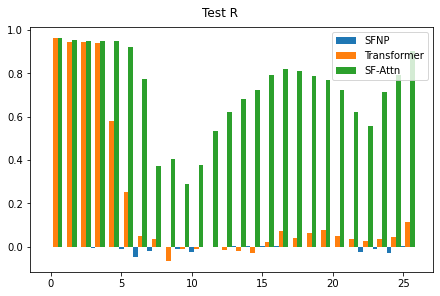

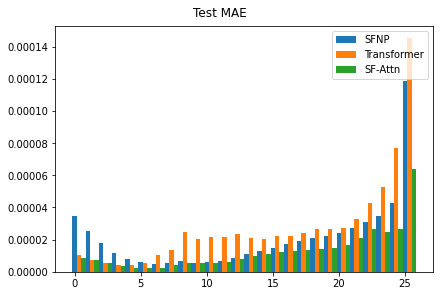

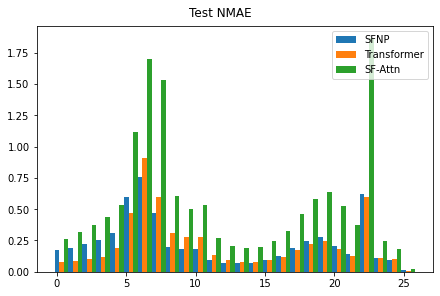

In [8]:
plot_bar("Test R", all_rs, labels)
plot_bar("Test MAE", all_maes, labels)
plot_bar("Test NMAE", all_nmaes, labels)